In [1]:
import pandas as pd
import os
import numpy as np
import sys
import pickle
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [2]:
from string import punctuation
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import  word_tokenize

In [3]:
# set the path
import os 
path = os.getcwd()
print (str(path))

/Users/austinlasseter/atelier/github_projects/repos_2020/nlp_fedregs


In [4]:
# maximize output width
pd.set_option('display.max_colwidth', -1)

In [5]:
df=pd.read_csv(path + "/training.csv", nrows=300) # Note: only some rows have been manually labeled.

In [6]:
df.tail(5)

,Comments,Immigrant_author,Supports,postedDate
295,We require this LAW to be implemented so as we could retain capable H1 resources as well get qualified depended to work for USA,0,1,2014-06-04T00:00:00-04:00
296,"No. If so, what's the difference between certain H4 and the H1? There are too many qualified H4 willing to work no matter how less the employer pays, then what happens to the H1 and all the mid-class?",0,0,2014-07-12T00:00:00-04:00
297,"I am strongly in the favor of this rule. This provides valuable workforce for the country with a huge pool of H-4 people who are unable to work even when highly qualified. This would boost the overall economy for the country. Also, I think not having the work authorization for dependent H-4 visa people is somewhat against the basic human principle. Everyone who are legally here should have the right to work and earn their livelihood to be independent. I am glad that this rule is finally about to come in effect.",0,0,2014-06-16T00:00:00-04:00
298,"Allowed to work is a fundamental human right. Stripping a portion of inhabitants of this country of that fundamental right is just unfair. These are well educated, well qualified, law abiding people who came in thru the right channels. Their lives cannot be punished because they chose to support their spouse. My wife is an MBA and is forced to sit at home just because of this rule.",0,0,2014-07-14T00:00:00-04:00
299,"I would think this rule is much necessary for any country which in support of Women Empowerment...As I understand from social trend , majority of dependent workers are women . So , if Govt . doesn' t allow the dependents to work it really hinders the professional growth which eventually reduces personality development in women which is against women empowerment . \r\r\n\r\r\nSince we are aiming at Women empowerment in all possible scenarios , I would suggest that the allowing the dependent to work will surely be a major step towards the social improvement across the globe.",0,0,2014-05-29T00:00:00-04:00


In [7]:
df.shape

(300, 4)

In [8]:
df.columns

Index(['Comments', 'Immigrant_author', 'Supports', 'postedDate'], dtype='object')

In [69]:
df['Immigrant_author'].value_counts()

0    217
1    83 
Name: Immigrant_author, dtype: int64

In [73]:
# Create the target variable
df['target'] = (df['Immigrant_author'] == 1)
df['target'].value_counts()

False    217
True     83 
Name: target, dtype: int64

In [74]:
# Oversample the target class
targets = df[df['Immigrant_author']==1]
df=df.append(targets)
len(df)

383

## Vectorize

In [75]:
tvec = TfidfVectorizer(# input='content', 
#                        encoding='utf-8', 
#                        decode_error='strict', 
                       strip_accents='unicode', 
                       lowercase=True, 
#                        preprocessor=None, 
#                        tokenizer=None, 
#                        analyzer='word', 
                       stop_words='english', 
#                        token_pattern='(?u)\\b\\w\\w+\\b', 
                       ngram_range=(1, 2), 
#                        max_df=1.0, 
#                        min_df=1, 
#                        max_features=None, 
#                        vocabulary=True, 
#                        binary=False, 
#                        dtype=<class 'numpy.int64'>, 
#                        norm='l2', 
#                        use_idf=True, 
#                        smooth_idf=True, 
#                        sublinear_tf=False
)

In [76]:
cleaned = tvec.fit_transform(df['Comments'])

In [77]:
# This gets used later on but it's defined here
word_counts = pd.DataFrame(cleaned.sum(axis=0),
                       columns=tvec.get_feature_names())
print('Most common: \n \n', word_counts.T.sort_values(by=0,ascending=False).head(10))

Most common: 
 
                  0
rule     12.714736
work     12.709177
h4       10.655166
economy  8.202231 
country  8.089063 
people   7.878209 
help     7.422364 
spouses  6.903945 
years    6.251263 
good     6.160451 


In [78]:
cleaned.shape

(383, 10399)

In [79]:
type(cleaned)

scipy.sparse.csr.csr_matrix

In [80]:
# pickle the vectorizer
file = open(f'vectorizer.pkl', 'wb')
pickle.dump(tvec, file)
file.close()

## Train-test Split

In [81]:
X = df['Comments']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .3, random_state=42)

In [82]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

268
268
115
115


In [83]:
# Note the difference in train and test. Don't fit on the test data! (d'oh)
tvec_train = tvec.fit_transform(X_train)
tvec_test  = tvec.transform(X_test)

# Random Forest Classifier

In [84]:
# grid search parameters
param_grid = {
        'n_estimators': [100, 'warn'], 
        'max_depth': [3, 4, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 5],         
        'max_features': [10, 'auto'], 
        'class_weight': [None]    
        }

In [85]:
# conduct gridsearch
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs = 1, cv=3)
grid.fit(tvec_train, y_train)
print(grid.best_params_)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

{'class_weight': None, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 150}

In [87]:
# Instantiate model using those parameters
model = grid.best_estimator_
print(model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


#### Predict

In [88]:
# Predict on the test data
predictions=model.predict(tvec_test)
print(len(y_test))
len(predictions)

115


115

In [89]:
# Probabilities
probabilities = model.predict_proba(tvec_test)[:,1]
len(probabilities)

115

In [90]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [91]:
# Accuracy score
metrics.accuracy_score(y_test, predictions)

0.9217391304347826

In [92]:
# Convert each component to a pandas dateframe
df_probs=pd.DataFrame(probabilities, columns=['probabilities']).reset_index(drop=True)
df_preds=pd.DataFrame(predictions, columns=['predictions']).reset_index(drop=True)
df_Xtest=pd.DataFrame(X_test).reset_index(drop=True)
df_ytest=pd.DataFrame(y_test).reset_index(drop=True)
# Reset a new index because we removed all the training data but never reset the index, so it has gaps
# and drop=True gets rid of the old index

final=pd.concat([df_Xtest, df_ytest, df_preds, df_probs], axis=1)
final.head()

,Comments,target,predictions,probabilities
0,"I think it is a welcome change, if it has been finalized that H4 spouses(certain H4s as defined) can get work authorization. Myself being a working mom and now on H4, and unable to work anymore or find a suitable job closeby, I believe every qualifying person should be able to work and earn his/her money. This will relieve the financial burden on a single working person , and improve overall health of the family and thus the society. Sure I will whole heartedly welcome H4 spouses getting work authorization",True,True,0.711000
1,Thanks to the Government to consider the concerns of H4 dependents.This will motivate and give energy to serve beter in USA for various clints. Also good opportunity to use our skills rather than sitting at home idle.,True,True,0.643889
2,"Right step in the right direction. It will provide a boost to the economy. Being forced to be a single income house hold for long doesn't do good for the housing market or the economy in general. The other advantage of this is that it helps integrate spouses to the society and gets them ready when the green card eventually happens.From a personal perspective , it makes the decision to to stay back Vs go to Bangalore a lot easier. No more ""I am sacrificing my career"" arguments :-) .",True,False,0.401095
3,"THis is a very good option to bring in ASAP. I am working in USA on H1B. When I got married, my wife who is an engineering gold medalist was working in India for one of the good Oil MNC. As she wanted to accompany me to USA she did a big sacrafice on resigning her good position and job to accompany me here on H4. As we were not successful to get the H1B Lottery she did her Masters (MS) in NYU university and completed with 3.85 GPA. We are a happy family with 2 kids now. As only reason she is not having a valid work permit she could not contribute any of her skills she studied to make her kid's life better than what it is now with a single salary. THis option will give her a opportunity to utilize her skills she studied for betterment of her, her family and also for this country too.",True,True,0.886500
4,It is a very good move by USCIS. I did my Master’s in business administration and then certification program in HR from USA. I used to work in the past but now I am on H-4 visa so cannot do anything. Thank you for considering this policy change.,True,False,0.311476


In [93]:
# Let's look at some that had intermediate probability
final[(final['probabilities']>0.45) & (final['probabilities']<0.55)]

,Comments,target,predictions,probabilities
21,"Great news, much-awaited rule.\r\r\nAll the qualified H4 spouses can work and live happily and don't forget they will pay taxes and contribute to US economy.\r\r\nWe H1 people contribute to US economy in each and every aspect, why our spouses are not allowed to work and stay at homes?\r\r\n\r\r\nI would love if this rule allows H4 people to give work authorization irrespective of immigration petition filed.\r\r\n\r\r\nI really welcome this rule and appreciate for the initiative.",False,False,0.492333
42,This initiative will help experienced/sound knowledge spouse to work and contribute to United Nations income and as well generate income for themselves. This will let many Families to have flexibility to generate income and improve the standard of living. I am an MBA with 6 years of experience in business Analysis and now sitting at home accompanying my spouse who has H1b. We would honor the move by US govt. Thank you for the opportunity.,True,False,0.469929
45,Its high time this rule is implemented .After investing my time and money in relocating to another country and gaining my MBA from a university in Iowa I am now back in my home country trying to start my career and life all over again. How come you need our spouses but not their skilled counterparts when we have done things the legal way and paid our taxes. How is it okay for illegal immigrants to get citizenship and not us. Please pass this rule and make America the land of opportunity and equality it used to be.,True,True,0.539825
79,Its high time this rule is implemented .After investing my time and money in relocating to another country and gaining my MBA from a university in Iowa I am now back in my home country trying to start my career and life all over again. How come you need our spouses but not their skilled counterparts when we have done things the legal way and paid our taxes. How is it okay for illegal immigrants to get citizenship and not us. Please pass this rule and make America the land of opportunity and equality it used to be.,True,True,0.539825
81,This initiative will help experienced/sound knowledge spouse to work and contribute to United Nations income and as well generate income for themselves. This will let many Families to have flexibility to generate income and improve the standard of living. I am an MBA with 6 years of experience in business Analysis and now sitting at home accompanying my spouse who has H1b. We would honor the move by US govt. Thank you for the opportunity.,True,False,0.469929


In [94]:
from sklearn import metrics
print(metrics.classification_report(y_test, predictions))
# Note: in a previous iteration, recall was .28!!

              precision    recall  f1-score   support

       False       0.89      0.98      0.93        65
        True       0.98      0.84      0.90        50

    accuracy                           0.92       115
   macro avg       0.93      0.91      0.92       115
weighted avg       0.93      0.92      0.92       115



#### Feature Importance 

In [95]:
df_x  = pd.DataFrame(tvec_test.todense(),
             columns=tvec.get_feature_names())
df_x.head(2)

,000,000 new,0001,0001 way,0017,0017 0001,0017 5602,0017 dear,065,065 existing,...,youth need,yrs,yrs companies,yrs h1b,yrs h4,yrs job,yrs lost,yrs tired,zealand,zealand australia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
fi = pd.DataFrame({
        'feature':df_x.columns,
        'importance':model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
8049,wife,0.032721
8386,years,0.017818
969,career,0.015298
112,able,0.012183
3946,india,0.011183
2607,family,0.009607
4434,life,0.009319
1714,degree,0.007878
3540,home,0.007640
4542,live,0.007008


In [97]:
top20=pd.DataFrame(fi.sort_values('importance', ascending=False).head(20))
top20

,feature,importance
8049,wife,0.032721
8386,years,0.017818
969,career,0.015298
112,able,0.012183
3946,india,0.011183
2607,family,0.009607
4434,life,0.009319
1714,degree,0.007878
3540,home,0.007640
4542,live,0.007008


In [98]:
# Features most associated with target
top10=pd.DataFrame(fi.sort_values('importance', ascending=False).head(10))
top10

,feature,importance
8049,wife,0.032721
8386,years,0.017818
969,career,0.015298
112,able,0.012183
3946,india,0.011183
2607,family,0.009607
4434,life,0.009319
1714,degree,0.007878
3540,home,0.007640
4542,live,0.007008


In [99]:
top10['feature'].values

array(['wife', 'years', 'career', 'able', 'india', 'family', 'life',
       'degree', 'home', 'live'], dtype=object)

In [100]:
top20['feature'].values

array(['wife', 'years', 'career', 'able', 'india', 'family', 'life',
       'degree', 'home', 'live', 'love', 'rule', 'opportunity', 'visa',
       'working', 'h4', 'confidence', 'work', 'work h4', 'country'],
      dtype=object)

Text(0, 0.5, 'Feature Importance')

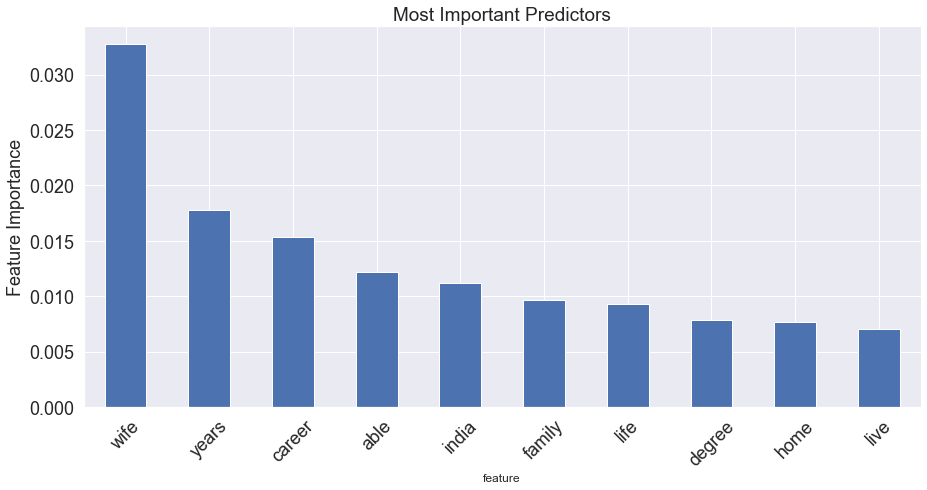

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top10.set_index('feature').plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18)

#### ROC-AUC Score

In [102]:
from sklearn import metrics
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.89      0.98      0.93        65
        True       0.98      0.84      0.90        50

    accuracy                           0.92       115
   macro avg       0.93      0.91      0.92       115
weighted avg       0.93      0.92      0.92       115



In [103]:
from sklearn.metrics import roc_curve, auc

In [104]:
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, probabilities)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [105]:
ROC_AUC

{1: 0.9803076923076923}

In [106]:
# What is that ROC-AUC score?
print(ROC_AUC[1])
# Same but using the scikit default:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, probabilities)

0.9803076923076923


0.9803076923076923

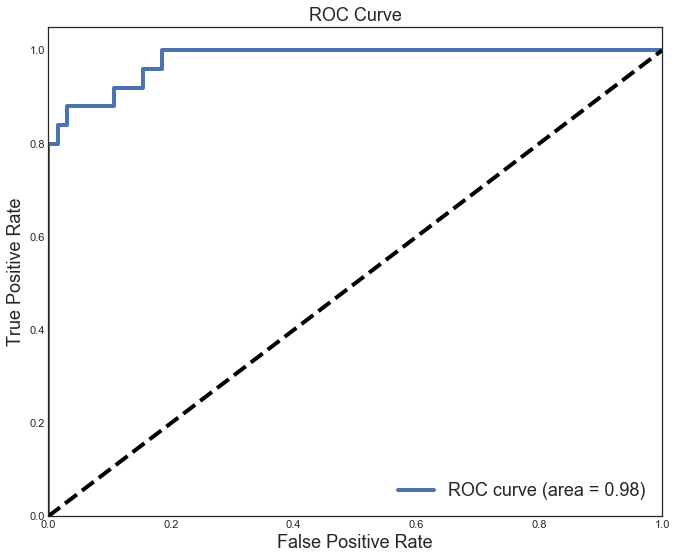

In [107]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

## Predict on new data

In [108]:
# create new data
comment_01="My family wholeheartedly welcome this proposed rule. This will make our lives a lot easier. My wife is a university topper in Economics, but cannot work because of the existing limitation with the H4 visa. It's hard to explain the frustration of such a person.\r\r\n\r\r\nCan't wait for this law to go in effect."

In [109]:
comment_02="Dear Officer,\r\r\n\r\r\nI strongly support this rule because this will give work authorization rights to many of the spouses who are currently struck and are not able to work despite of having well qualified education.\r\r\n\r\r\nFor my case my spouse is well qualified to be able to contribute to the US economy but she cannot work as she is on H4. She is MBA + CPA ( from WA state jurisdiction). Just imagine how many of the H4 spouses will be out there who cannot work just because of the restrictions on H4. I'm pretty sure with this rule implemented you will be able to extract the best out of your available resources here.\r\r\n\r\r\nWith this rule in action, it will give us world of confidence in this broken immigration system,help us to make big decisions to settle back in USA by investing here such as buying new home,new car and work on our dream start-up company, will create jobs and boost economy.\r\r\n\r\r\nThis rule is no Brain Drainer, providing EAD to those certain spouses who are already in line for permanent residence process along with their spouse GC process;they are possible future US citizen(in line).By providing EAD in advance will help build our life,economy and future of this country into right direction.\r\r\n\r\r\nSincerely,\r\r\n\r\r\nPuneet Marhatha"

In [110]:
comment_03='life and love my wife we make our lives we appreciate the experience of sitting at home in the past years. I strongly support this rule because this will give work authorization rights. This will make our lives a lot easier. My wife is a university topper. life and love my wife we make our lives we appreciate the experience of sitting at home in the past years ' 

In [111]:
comment_04='wife, love, came, day, life, past, single, experience, years, sitting home, able, coming, country, used work, children, visa restrictions, having status, appreciate, wife engineering, helps families'

In [121]:
comment_05='But, in a larger sense, we can not dedicate—we can not consecrate—we can not hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it, far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom—and that government of the people, by the people, for the people, shall not perish from the earth.'

In [122]:
new_df=pd.DataFrame({'comments':[comment_01, comment_02, comment_03, comment_04, comment_05]})
new_df

,comments
0,"My family wholeheartedly welcome this proposed rule. This will make our lives a lot easier. My wife is a university topper in Economics, but cannot work because of the existing limitation with the H4 visa. It's hard to explain the frustration of such a person.\r\r\n\r\r\nCan't wait for this law to go in effect."
1,"Dear Officer,\r\r\n\r\r\nI strongly support this rule because this will give work authorization rights to many of the spouses who are currently struck and are not able to work despite of having well qualified education.\r\r\n\r\r\nFor my case my spouse is well qualified to be able to contribute to the US economy but she cannot work as she is on H4. She is MBA + CPA ( from WA state jurisdiction). Just imagine how many of the H4 spouses will be out there who cannot work just because of the restrictions on H4. I'm pretty sure with this rule implemented you will be able to extract the best out of your available resources here.\r\r\n\r\r\nWith this rule in action, it will give us world of confidence in this broken immigration system,help us to make big decisions to settle back in USA by investing here such as buying new home,new car and work on our dream start-up company, will create jobs and boost economy.\r\r\n\r\r\nThis rule is no Brain Drainer, providing EAD to those certain spouses who are already in line for permanent residence process along with their spouse GC process;they are possible future US citizen(in line).By providing EAD in advance will help build our life,economy and future of this country into right direction.\r\r\n\r\r\nSincerely,\r\r\n\r\r\nPuneet Marhatha"
2,life and love my wife we make our lives we appreciate the experience of sitting at home in the past years. I strongly support this rule because this will give work authorization rights. This will make our lives a lot easier. My wife is a university topper. life and love my wife we make our lives we appreciate the experience of sitting at home in the past years
3,"wife, love, came, day, life, past, single, experience, years, sitting home, able, coming, country, used work, children, visa restrictions, having status, appreciate, wife engineering, helps families"
4,"But, in a larger sense, we can not dedicate—we can not consecrate—we can not hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it, far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom—and that government of the people, by the people, for the people, shall not perish from the earth."


In [123]:
# open the pickle file
file = open(f'vectorizer.pkl', 'rb')
tvec_pkl=pickle.load(file)
file.close()

In [124]:
# vectorize
tvec_01 = tvec.transform(new_df['comments'])

In [125]:
# predict using the same model we defined earlier
predictions=model.predict(tvec_01)

In [126]:
# create a new column with the predictions
new_df['preds'] = predictions
new_df

,comments,preds
0,"My family wholeheartedly welcome this proposed rule. This will make our lives a lot easier. My wife is a university topper in Economics, but cannot work because of the existing limitation with the H4 visa. It's hard to explain the frustration of such a person.\r\r\n\r\r\nCan't wait for this law to go in effect.",True
1,"Dear Officer,\r\r\n\r\r\nI strongly support this rule because this will give work authorization rights to many of the spouses who are currently struck and are not able to work despite of having well qualified education.\r\r\n\r\r\nFor my case my spouse is well qualified to be able to contribute to the US economy but she cannot work as she is on H4. She is MBA + CPA ( from WA state jurisdiction). Just imagine how many of the H4 spouses will be out there who cannot work just because of the restrictions on H4. I'm pretty sure with this rule implemented you will be able to extract the best out of your available resources here.\r\r\n\r\r\nWith this rule in action, it will give us world of confidence in this broken immigration system,help us to make big decisions to settle back in USA by investing here such as buying new home,new car and work on our dream start-up company, will create jobs and boost economy.\r\r\n\r\r\nThis rule is no Brain Drainer, providing EAD to those certain spouses who are already in line for permanent residence process along with their spouse GC process;they are possible future US citizen(in line).By providing EAD in advance will help build our life,economy and future of this country into right direction.\r\r\n\r\r\nSincerely,\r\r\n\r\r\nPuneet Marhatha",True
2,life and love my wife we make our lives we appreciate the experience of sitting at home in the past years. I strongly support this rule because this will give work authorization rights. This will make our lives a lot easier. My wife is a university topper. life and love my wife we make our lives we appreciate the experience of sitting at home in the past years,True
3,"wife, love, came, day, life, past, single, experience, years, sitting home, able, coming, country, used work, children, visa restrictions, having status, appreciate, wife engineering, helps families",True
4,"But, in a larger sense, we can not dedicate—we can not consecrate—we can not hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it, far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom—and that government of the people, by the people, for the people, shall not perish from the earth.",False


In [127]:
# Probabilities
new_df['probs'] = model.predict_proba(tvec_01)[:,1]
new_df

,comments,preds,probs
0,"My family wholeheartedly welcome this proposed rule. This will make our lives a lot easier. My wife is a university topper in Economics, but cannot work because of the existing limitation with the H4 visa. It's hard to explain the frustration of such a person.\r\r\n\r\r\nCan't wait for this law to go in effect.",True,0.921667
1,"Dear Officer,\r\r\n\r\r\nI strongly support this rule because this will give work authorization rights to many of the spouses who are currently struck and are not able to work despite of having well qualified education.\r\r\n\r\r\nFor my case my spouse is well qualified to be able to contribute to the US economy but she cannot work as she is on H4. She is MBA + CPA ( from WA state jurisdiction). Just imagine how many of the H4 spouses will be out there who cannot work just because of the restrictions on H4. I'm pretty sure with this rule implemented you will be able to extract the best out of your available resources here.\r\r\n\r\r\nWith this rule in action, it will give us world of confidence in this broken immigration system,help us to make big decisions to settle back in USA by investing here such as buying new home,new car and work on our dream start-up company, will create jobs and boost economy.\r\r\n\r\r\nThis rule is no Brain Drainer, providing EAD to those certain spouses who are already in line for permanent residence process along with their spouse GC process;they are possible future US citizen(in line).By providing EAD in advance will help build our life,economy and future of this country into right direction.\r\r\n\r\r\nSincerely,\r\r\n\r\r\nPuneet Marhatha",True,0.808833
2,life and love my wife we make our lives we appreciate the experience of sitting at home in the past years. I strongly support this rule because this will give work authorization rights. This will make our lives a lot easier. My wife is a university topper. life and love my wife we make our lives we appreciate the experience of sitting at home in the past years,True,0.748333
3,"wife, love, came, day, life, past, single, experience, years, sitting home, able, coming, country, used work, children, visa restrictions, having status, appreciate, wife engineering, helps families",True,0.786119
4,"But, in a larger sense, we can not dedicate—we can not consecrate—we can not hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it, far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom—and that government of the people, by the people, for the people, shall not perish from the earth.",False,0.143833
